In [ ]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

# Quickstart

TODO: write a nice quickstart guide with RT and EM fields, as well as optimization?

In [11]:
import equinox as eqx
import jax.numpy as jnp

from differt.scene.sionna import download_sionna_scenes, get_sionna_scene
from differt.scene.triangle_scene import TriangleScene

# TODO: show how to reproduce https://nvlabs.github.io/sionna/examples/Sionna_Ray_Tracing_Introduction.html?

In [12]:
download_sionna_scenes()  # Let's download Sionna scenes (from the main branch)

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
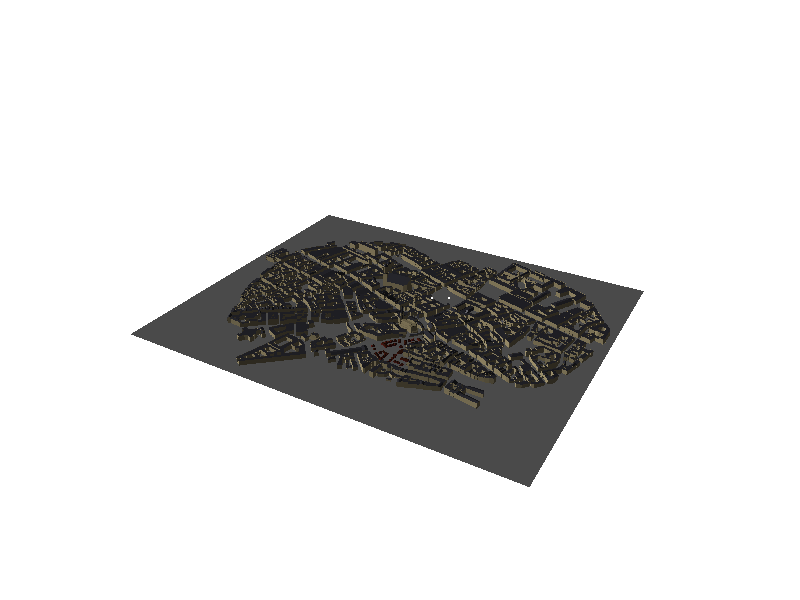

In [14]:
file = get_sionna_scene("munich")
scene = TriangleScene.load_xml(file)
scene = eqx.tree_at(lambda s: s.transmitters, scene, jnp.array([[8.5, 21, 27]]))
scene = eqx.tree_at(lambda s: s.receivers, scene, jnp.array([[45, 90, 1.5]]))
scene.plot()